# Tolkbar Maskinlæring

Denne jupyter notebooken er laga i samband med While1Create 25 April 2023.
Her tek vi for oss litt kodeeksempel frå diverse pythonbibliotek. 

## Importer bibliotek og datasett

Last inn naudsynte bibliotek, datasettet me nytter er [UCL Bike Sharing Dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

In [2]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import r2_score

## Rydd litt i dataen

In [3]:
data = pd.read_csv('data/day.csv')
data = data.set_index('dteday')
# De-normaliser temperatur
data['temp'] = data['temp'] * (39 - (-8)) + (-8)
data['atemp'] = data['atemp'] * (50 - (-16)) + (-16)
data['windspeed'] = data['windspeed'] * 67
data['hum'] = data['hum'] * 100

# Fjern verdier som ikkje er av interesse
data = data.drop(
    [
        'instant',
        'registered',
        'casual',
        'atemp'
    ],
    axis = 1
)

# Oversett
numeric_var = {
                "season": {1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'},
                "weathersit" : {1:'Clear', 2:'Mist', 3:'Rain', 4:'Rain'}
            }
data = data.replace(numeric_var)

# Gjer om kategorisk til binær
onehot = pd.get_dummies(data.season, prefix="season")
data = data.drop('season', axis=1)
data = data.join(onehot)

# Gjer om kategorisk til binær
onehot = pd.get_dummies(data.weathersit, prefix="weather")
data = data.drop('weathersit', axis=1)
data = data.join(onehot)

data

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_Fall,season_Spring,season_Summer,season_Winter,weather_Clear,weather_Mist,weather_Rain
dteday,,,,,,,,,,,,,,,,
2011-01-01,0,1,0,6,0,8.175849,80.5833,10.749882,985,0,0,0,1,0,1,0
2011-01-02,0,1,0,0,0,9.083466,69.6087,16.652113,801,0,0,0,1,0,1,0
2011-01-03,0,1,0,1,1,1.229108,43.7273,16.636703,1349,0,0,0,1,1,0,0
2011-01-04,0,1,0,2,1,1.400000,59.0435,10.739832,1562,0,0,0,1,1,0,0
2011-01-05,0,1,0,3,1,2.666979,43.6957,12.522300,1600,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,12,0,4,1,3.945849,65.2917,23.458911,2114,0,0,0,1,0,1,0
2012-12-28,1,12,0,5,1,3.906651,59.0000,10.416557,3095,0,0,0,1,0,1,0
2012-12-29,1,12,0,6,0,3.906651,75.2917,8.333661,1341,0,0,0,1,0,1,0


## Hent ut variablar

- X: Uavhengige variablar (Forklaringsvariablar)
- y: Avhengig variabel (Responsvariabel)

Desse må konverterast til numpy arrays da scikit-learn krever det. Dette gjer ein
ved .values på slutten av ein Pandas Dataframe

In [4]:
y, X = dmatrices(
    'cnt ~ season_Spring + season_Summer + season_Fall + season_Winter + weather_Clear + weather_Mist + weather_Rain + workingday + yr + holiday + weekday + workingday + temp + hum + windspeed', 
    data=data, return_type='dataframe'
)

## Tren lineær regresjon

In [5]:
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     286.5
Date:                Tue, 25 Apr 2023   Prob (F-statistic):          3.71e-264
Time:                        07:01:07   Log-Likelihood:                -5928.0
No. Observations:                 731   AIC:                         1.188e+04
Df Residuals:                     718   BIC:                         1.194e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1432.7359    173.059      8.279      0.000    1092.974    1772.498
season_Spring   616.1221     73.081      8.431      0.000     472.644     759.600
season_Summer   319.2239     98.171      3.252      0.001     126.488     511.960
season_Fall    1020.1027     71.177     14.332      0.000     880.363    1159.842
season_Winter  -522.7128     81.548     -6.410      0.000    -682.815    -362.611
weather_Clear  1283.1431     64.203     19.986      0.000    1157.095    1409.191
weather_Mist    830.4318     83.407      9.956      0.000     666.682     994.182
weather_Rain   -680.8390    165.485     -4.114      0.000   -1005.731    -355.947
workingday      116.4117     67.073      1.736      0.083     -15.271     248.095
yr             2017.6682     60.992     33.081      0.000    1897.925    2137.412
holiday        -545.9717    186.950     -2.920      0.004    -913.005    -178.938
weekday          66.3330     15.141      4.381      0.000      36.608      96.059
temp            108.3550      6.451     16.797      0.000      95.690     121.020
hum             -12.0928      2.926     -4.133      0.000     -17.838      -6.348
windspeed       -41.3681      6.310     -6.556      0.000     -53.757     -28.980
==============================================================================
Omnibus:                       96.175   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.429
Skew:                          -0.722   Prob(JB):                     3.04e-49
Kurtosis:                       5.291   Cond. No.                     1.72e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

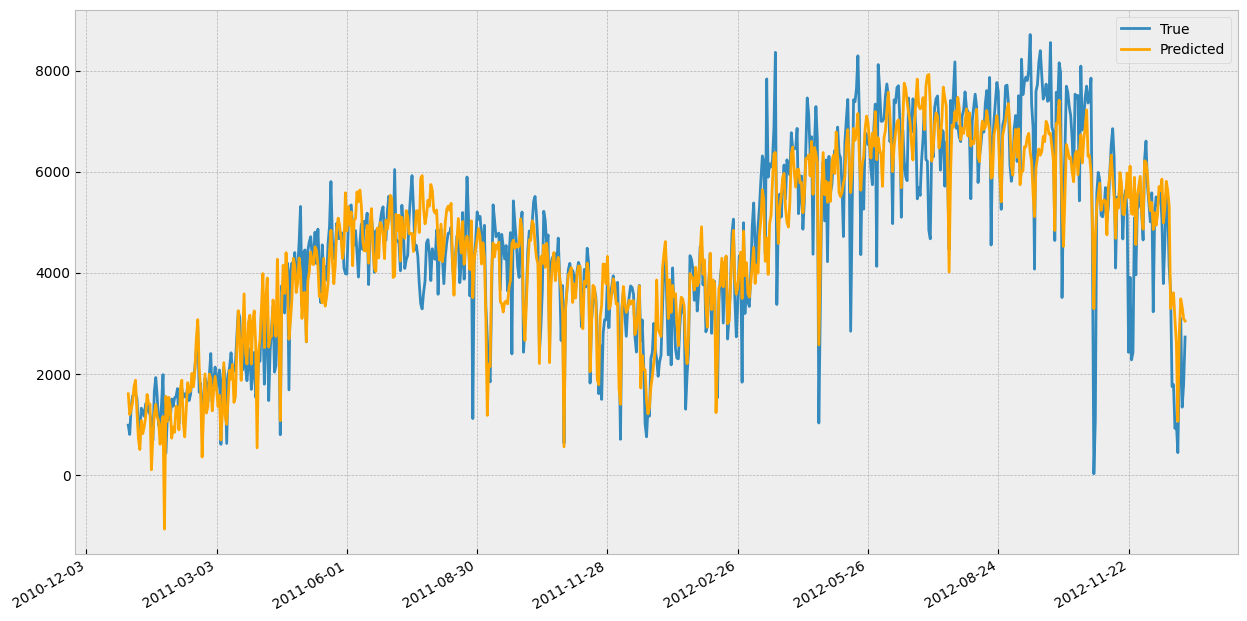

In [6]:
y_true = y
y_true.index = pd.to_datetime(y_true.index)
y_pred = res.predict(X)
y_pred.index = pd.to_datetime(y_pred.index)

plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
ax.plot(y_true.index, y_true, label='True')
ax.plot(y_pred.index, y_pred, label='Predicted', color='orange')
ax.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.gcf().autofmt_xdate()

## Vekt illustrasjon

/tmp/ipykernel_101418/2792275466.py:17: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


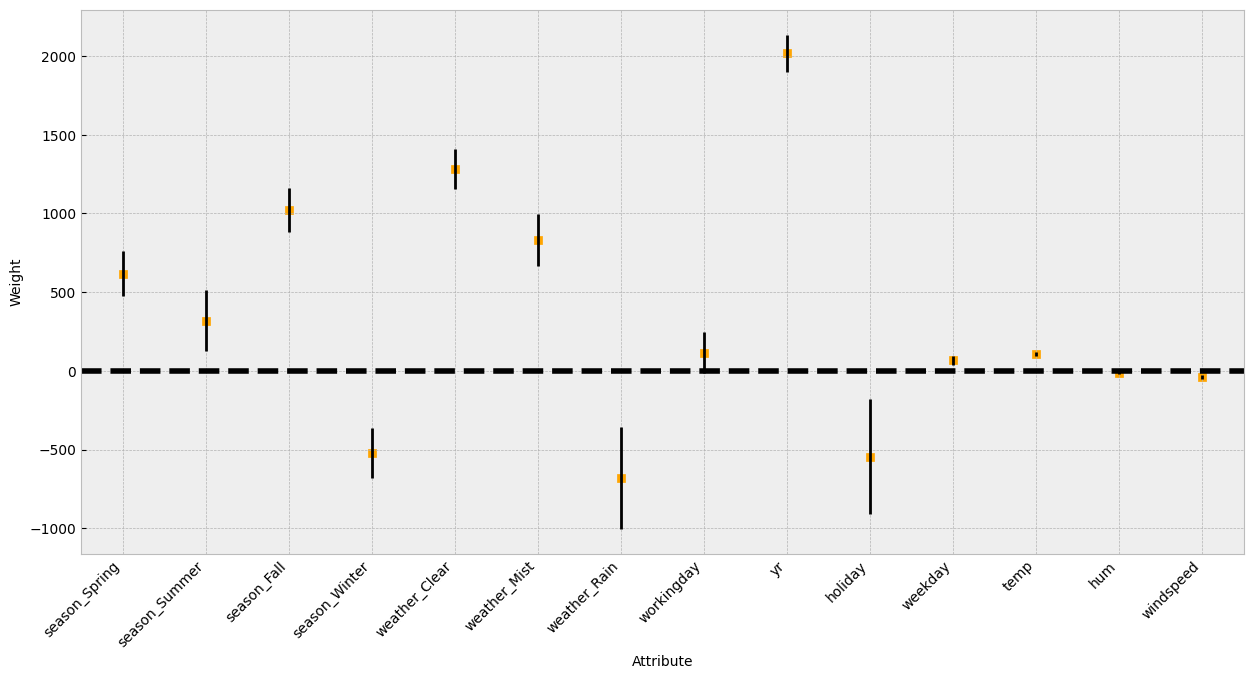

In [56]:
err_series = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef': res.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })


fig, ax = plt.subplots(figsize=(15, 8))
plt.style.use('bmh')
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Weight')
ax.set_xlabel('Attribute')

ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=30, 
           y=coef_df['coef'], color='orange')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
fig.autofmt_xdate(rotation=45)

## Effekt Illustrasjon



/tmp/ipykernel_101418/3547202735.py:44: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(plotdf.shape[0]),


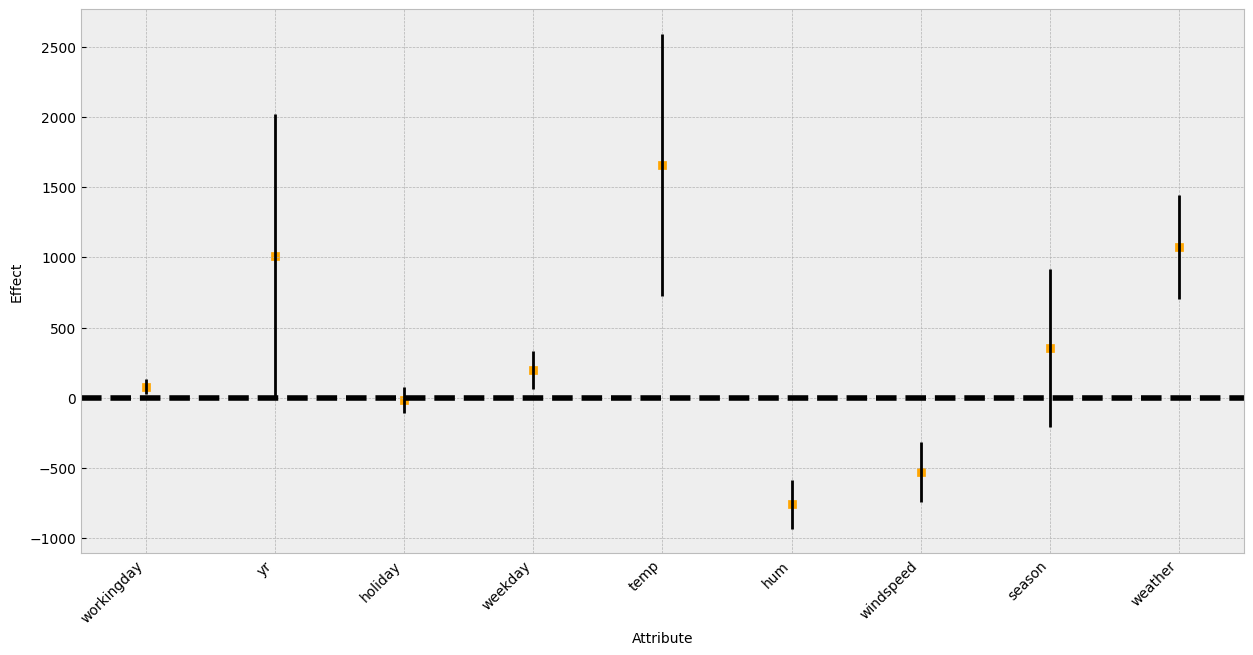

In [66]:
coef_df = pd.DataFrame({'coef': res.params.values[:]
                       },
                       index=res.params.index)

effect = pd.DataFrame()

for column in X:
    effect[column] = X[column] * coef_df.loc[column].values[0]

# Merge dummies
effect['season'] = effect['season_Spring'] + effect['season_Summer'] + \
    effect['season_Fall'] + effect['season_Winter']
effect = effect.drop([
    'season_Spring', 'season_Summer', 'season_Fall', 'season_Winter'
], axis=1)

# Merge dummies
effect['weather'] = effect['weather_Clear'] + effect['weather_Mist'] + \
      effect['weather_Rain']
      
effect = effect.drop([
    'weather_Clear', 'weather_Mist', 'weather_Rain'
], axis=1)

# Transformer dataframe til format for plot
plotdf = effect.describe().T
plotdf = plotdf.reset_index()
plotdf = plotdf.rename(
    columns={'mean' : 'coef', 'std' : 'err', 'index' : 'varname'}
) 

# Fjern Intercept
plotdf = plotdf[1:]

fig, ax = plt.subplots(figsize=(15, 8))
plt.style.use('bmh')
plotdf.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Effect')
ax.set_xlabel('Attribute')

ax.scatter(x=pd.np.arange(plotdf.shape[0]), 
           marker='s', s=30, 
           y=plotdf['coef'], color='orange')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
fig.autofmt_xdate(rotation=45)